In [123]:
import models_BCGCN as model
import functions

In [124]:
import torch
import numpy as np
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn

In [125]:
class GPC(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(GPC, self).__init__()
		self.out_dim = out_dim
		self.conv = nn.Conv2d(in_dim, out_dim, (1, node))
		nn.init.normal_(self.conv.weight, std=math.sqrt(2/(node*in_dim+node*out_dim)))

	def forward(self, x):
		batchsize = x.shape[0]

		x_c = self.conv(x)
		x_C = x_c.expand(batchsize, self.out_dim, node, node)
		x_R = x_C.permute(0,1,3,2)
		x = x_C+x_R

		return x

class EP(nn.Module):

	def __init__(self, in_dim, out_dim):
		super(EP, self).__init__()
		self.conv = nn.Conv2d(in_dim, out_dim, (1, node))
		nn.init.normal_(self.conv.weight, std=math.sqrt(4/(node*in_dim+out_dim)))


	def forward(self, x):

		x = self.conv(x)

		return x

class NP(nn.Module):

	def __init__(self, in_dim, out_dim):
		super(NP, self).__init__()
		self.conv = nn.Conv2d(in_dim, out_dim, (node, 1))
		nn.init.normal_(self.conv.weight, std=math.sqrt(4/(node*in_dim+out_dim)))

	def forward(self, x):

		x = self.conv(x)

		return x

class BC_GCN(nn.Module):
	def __init__(self, GPC_dim_1, GPC_dim_2, GPC_dim_3, EP_dim, NP_dim):
		super(BC_GCN, self).__init__()

		print('Current model : BC_GCN')

		self.GPC_1 = GPC(1, GPC_dim_1)
		self.GPC_2 = GPC(GPC_dim_1, GPC_dim_2)
		self.GPC_3 = GPC(GPC_dim_2, GPC_dim_3)

		self.EP = EP(GPC_dim_3, EP_dim)

		self.NP = NP(EP_dim, NP_dim)

		self.fc = nn.Linear(NP_dim, n_classes)
		nn.init.constant_(self.fc.bias, 0)

	def forward(self, x):

		x = self.GPC_1(x)
		x = F.relu(x)

		x = self.GPC_2(x)
		x = F.relu(x)

		x = self.GPC_3(x)
		x = F.relu(x)

		x = self.EP(x)
		x = F.relu(x)

		x = self.NP(x)
		x = F.relu(x)

		x = x.view(x.size(0),-1)

		x = self.fc(x)


		return x

def weights_init(m):
	if isinstance(m, nn.Conv2d):
		#nn.init.kaiming_normal_(m.weight, mode='fan_out')
		#nn.init.xavier_uniform_(m.weight)
		nn.init.constant_(m.bias, 0)
	elif isinstance(m, nn.Linear):
		nn.init.xavier_uniform_(m.weight)
		#nn.init.constant_(m.bias, 0)

In [126]:
#GLOBAL VARIABLES
node = 116
n_classes = 3
g_labels = torch.from_numpy(np.loadtxt('ADNI_gsr_172/labels.csv', delimiter=','))
g_labels = g_labels.type(torch.LongTensor)

In [127]:
full_train_data = functions.load_pcorr()
idx = functions.filter_SMC_patient_info()
data = [full_train_data[i] for i in idx]
data = np.array(data)
data = torch.from_numpy(data)
data = data.type(torch.float32)
data = torch.reshape(data ,(172 , 1 ,116 , 116))

In [128]:
kf = StratifiedKFold(n_splits=5, shuffle=False)
for train_val_idx, test_idx in kf.split(data, g_labels):
	X_train_val = data[train_val_idx]
	X_test      = data[test_idx]
	Y_train_val = g_labels[train_val_idx]
	Y_test      = g_labels[test_idx]

	X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_val, Y_train_val , test_size=0.125,
                                                    random_state=42, stratify=Y_train_val)

In [129]:
train_data = []
for i in range(len(X_train)):
	train_data.append([X_train[i] , Y_train[i]])

valid_data = []
for i in range(len(X_valid)):
	valid_data.append([X_valid[i] , Y_valid[i]])

test_data = []
for i in range(len(X_test)):
	test_data.append([X_test[i] , Y_test[i]])

In [130]:
train_loader = DataLoader(train_data, batch_size=5)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [161]:
torch.count_nonzero(Y_train == 0)

tensor(33)

In [171]:
#apply weights to the crossentropy loss using training data labels
lab = [0 , 1 , 2]
weight = []
for i in lab:
	weight.append(np.count_nonzero(Y_train == i) / len(Y_train))
weight = torch.FloatTensor(weight)
class_weights = 1 / weight
print(torch.FloatTensor(class_weights))

tensor([3.6364, 1.8462, 5.4545])


In [172]:
net = BC_GCN(16, 16, 16, 64, 256)
net.apply(weights_init)
optimizer = optim.SGD(net.parameters(), lr=0.0003, momentum=0.9, weight_decay=0)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

#TODO: introduce ADAM optimizer
loss_list = []
val_acc_list = []
for i in range(50):
	net.train()
	runtime_loss = 0
	for data in train_loader:
		inputs = data[0]
		labels = data[1]
		optimizer.zero_grad()
		outputs = net(inputs)
		loss = criterion(outputs, labels)
		runtime_loss += loss.item()
		loss.backward()
		optimizer.step()
	loss_list.append(runtime_loss / len(train_loader))

	net.eval()
	correct = 0
	for data in valid_loader:
		inputs = data[0]
		labels = data[1]
		outputs = net(inputs)
		pred = outputs.argmax(dim=1)
		print(pred)
		correct += int((pred == labels).sum())
	val_acc = correct / len(valid_loader.dataset)
	val_acc_list.append(val_acc)
	print(f'Epoche : {i}    Val Acc:{val_acc} ')

net.eval()
correct = 0
for data in test_data:
	inputs = data[0]
	labels = data[1]
	outputs = net(inputs)
	pred = outputs.argmax(dim=1)
	correct += int((pred == labels).sum())
test_acc = correct / len(test_loader.dataset)
print(f'Test Acc:{test_acc} ')



Current model : BC_GCN
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoche : 0    Val Acc:0.5555555555555556 
tensor([1, 0, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoche : 1    Val Acc:0.4444444444444444 
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoche : 2    Val Acc:0.5555555555555556 
tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1])
Epoche : 3    Val Acc:0.5555555555555556 
tensor([1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1])
Epoche : 4    Val Acc:0.5 
tensor([1, 0, 2, 2, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1])
Epoche : 5    Val Acc:0.3333333333333333 
tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1])
Epoche : 6    Val Acc:0.4444444444444444 
tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])
Epoche : 7    Val Acc:0.5555555555555556 
tensor([1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1])
Epoche : 8    Val Acc:0.3333333333333333 
tensor([2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 

[1.0945609932144482, 0.9929234261314074, 0.8929274367789427, 0.7467238083481789, 0.5644708812857667, 0.35869535120824975, 0.3309679611896475, 0.5139413361127178, 0.7185958845851322, 0.6954933512024581, 0.8013617619872093, 0.601044618524611, 0.3242087932303548, 0.3631753420922905, 0.43398195739185513, 0.3982108210523923, 0.40228714685266215, 0.4238267722709376, 0.3837545118294656, 0.20254710572771728, 0.2805750545036669, 0.3597386048641056, 0.48720961762592196, 0.32714533095713705, 0.4371731666033156, 0.6725490142901739, 0.5568570159375668, 0.3093406152911484, 0.2981642459635623, 0.38963283761889517, 0.19464447523932904, 0.10161547648385749, 0.24520110008935112, 0.16268057920994275, 0.08930336973935482, 0.03688708397870263, 0.00561400852211591, 0.002349377860355162, 0.0015381200394889067, 0.0011516709206868352, 0.0009164549187516968, 0.0007568835765141557, 0.0006413579336215965, 0.0005540517876549226, 0.00048629543478758325, 0.00043206596728850855, 0.00038776196570703786, 0.000351109015

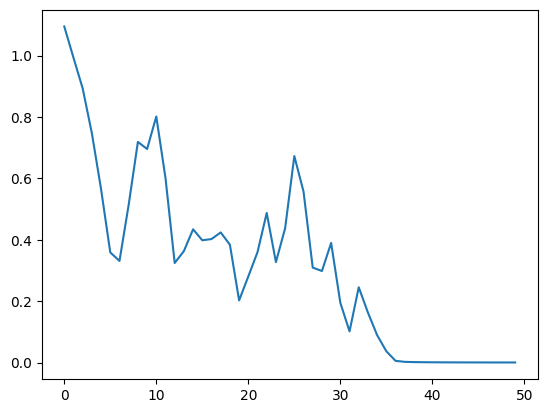

In [112]:
print(loss_list)
plt.plot(loss_list)
plt.show()

In [105]:
#todo: add weights
#todo: include dropout

24
